*Step* 1: Data Preparation


In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset
data_path = '/content/MLoGPU_data1_train.csv'
df = pd.read_csv(data_path)

# Separate features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


Step 2: Defining the MLP Model


In [2]:
import torch.nn as nn
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


Step 3: Model Training, Evaluation, and Comparison.


In [3]:
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import numpy as np

def train_and_evaluate(device, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor):
    results = {
        'device': device.type,
        'training_time': 0,
        'inference_time': 0,
        'accuracy': 0
    }

    print(f"Training on {device}")

    # Model setup
    model = SimpleMLP(input_size=10, hidden_size=100, num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training
    start_time = time.time()
    for epoch in range(1000):  # The number of epochs
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

    results['training_time'] = time.time() - start_time

    # Inference
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == y_test_tensor).sum().item()

    results['inference_time'] = time.time() - start_time
    results['accuracy'] = 100 * correct / len(y_test_tensor)

    print(f'Accuracy: {results["accuracy"]}%')
    print(f'Inference Time: {results["inference_time"]:.4f} seconds')

    return results

device = torch.device('cpu')
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = [x.to(device) for x in [X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor]]

# Collect results for both CPU and GPU
results = []
for device in ['cpu'] + (['cuda'] if torch.cuda.is_available() else []):
    torch_device = torch.device(device)
    results.append(train_and_evaluate(torch_device,
                                      X_train_tensor.to(torch_device),
                                      y_train_tensor.to(torch_device),
                                      X_test_tensor.to(torch_device),
                                      y_test_tensor.to(torch_device)))



Training on cpu
Epoch [10/100], Loss: 2.1123
Epoch [20/100], Loss: 1.8560
Epoch [30/100], Loss: 1.6593
Epoch [40/100], Loss: 1.5152
Epoch [50/100], Loss: 1.4128
Epoch [60/100], Loss: 1.3401
Epoch [70/100], Loss: 1.2866
Epoch [80/100], Loss: 1.2455
Epoch [90/100], Loss: 1.2130
Epoch [100/100], Loss: 1.1869
Epoch [110/100], Loss: 1.1656
Epoch [120/100], Loss: 1.1482
Epoch [130/100], Loss: 1.1338
Epoch [140/100], Loss: 1.1218
Epoch [150/100], Loss: 1.1117
Epoch [160/100], Loss: 1.1029
Epoch [170/100], Loss: 1.0954
Epoch [180/100], Loss: 1.0887
Epoch [190/100], Loss: 1.0828
Epoch [200/100], Loss: 1.0774
Epoch [210/100], Loss: 1.0724
Epoch [220/100], Loss: 1.0677
Epoch [230/100], Loss: 1.0633
Epoch [240/100], Loss: 1.0591
Epoch [250/100], Loss: 1.0551
Epoch [260/100], Loss: 1.0512
Epoch [270/100], Loss: 1.0475
Epoch [280/100], Loss: 1.0439
Epoch [290/100], Loss: 1.0404
Epoch [300/100], Loss: 1.0370
Epoch [310/100], Loss: 1.0337
Epoch [320/100], Loss: 1.0305
Epoch [330/100], Loss: 1.0273
Epo

Step 4:Plotting the results

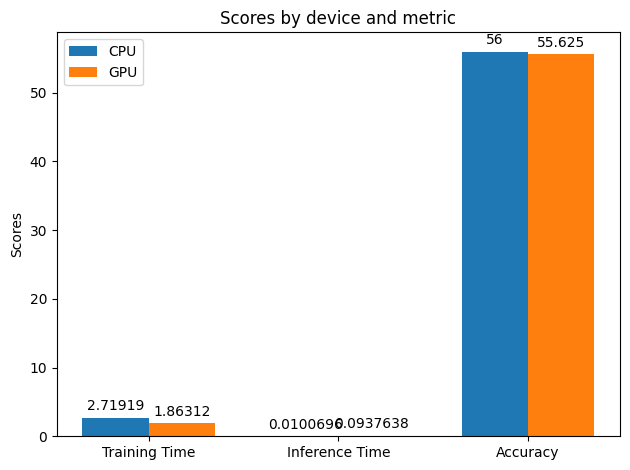

In [4]:
# Plotting
labels = ['Training Time', 'Inference Time', 'Accuracy']
cpu_data = [results[0]['training_time'], results[0]['inference_time'], results[0]['accuracy']]
gpu_data = [results[1]['training_time'], results[1]['inference_time'], results[1]['accuracy']] if len(results) > 1 else [0, 0, 0]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, cpu_data, width, label='CPU')
rects2 = ax.bar(x + width/2, gpu_data, width, label='GPU' if len(results) > 1 else 'No GPU')

ax.set_ylabel('Scores')
ax.set_title('Scores by device and metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()
